In [14]:
import os
import pathlib
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from dateutil import parser
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [10]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"

# Data Loading and Preprocessing

- Import the data
- Preprocess the data
- Turn the data into tensor

In [24]:
# Import the data
raw_epa_taiwan_dir = raw_data_dir / "epa_taiwan"
epa_taiwan_csv_list = glob.glob(f'{str(raw_epa_taiwan_dir)}/*.csv')

In [25]:
epa_taiwan_df = pd.concat([pd.read_csv(csv) for csv in tqdm(epa_taiwan_csv_list)])

  0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
pm25 = epa_taiwan_df[[
    "SiteEngName",
    "PM2.5",
    "AMB_TEMP",
    "CH4",
    'CO',
    "NMHC",
    # "lon",
    # "lat",
    "read_time"
    ]]

In [96]:
pm25_banqiao = pm25[pm25['SiteEngName'] == "Banqiao"]

# simplify the column names
# remove non alpha numeric, convert all to lowercase
col_name_mapping = {_: _.lower() for _ in pm25_banqiao.columns}
pm25_banqiao = pm25_banqiao.rename(columns=col_name_mapping)

# convert tp datetime format

# Function to convert datetime to naive datetime
def convert_to_naive(dt):
    dt_obj = parser.parse(dt)
    return dt_obj.replace(tzinfo=None)

pm25_banqiao['read_time'] = pd.to_datetime(pm25_banqiao['read_time'].apply(convert_to_naive))

# sort the dataframe based on read_time
pm25_banqiao = pm25_banqiao.sort_values(by="read_time")

In [98]:
# make sure the time diff is always constant
pm25_banqiao['time_diff'] = pm25_banqiao['read_time'].diff()
time_diff_list = pm25_banqiao['time_diff'].unique().dropna()

if len(time_diff_list) > 1:
    print(f"{time_diff_list.unique()}")
else:
    print(f"time difference is always: {time_diff_list[0]}")
    pm25_banqiao = pm25_banqiao.drop(columns=["time_diff"])
    pm25_banqiao.head()

time difference is always: 0 days 01:00:00


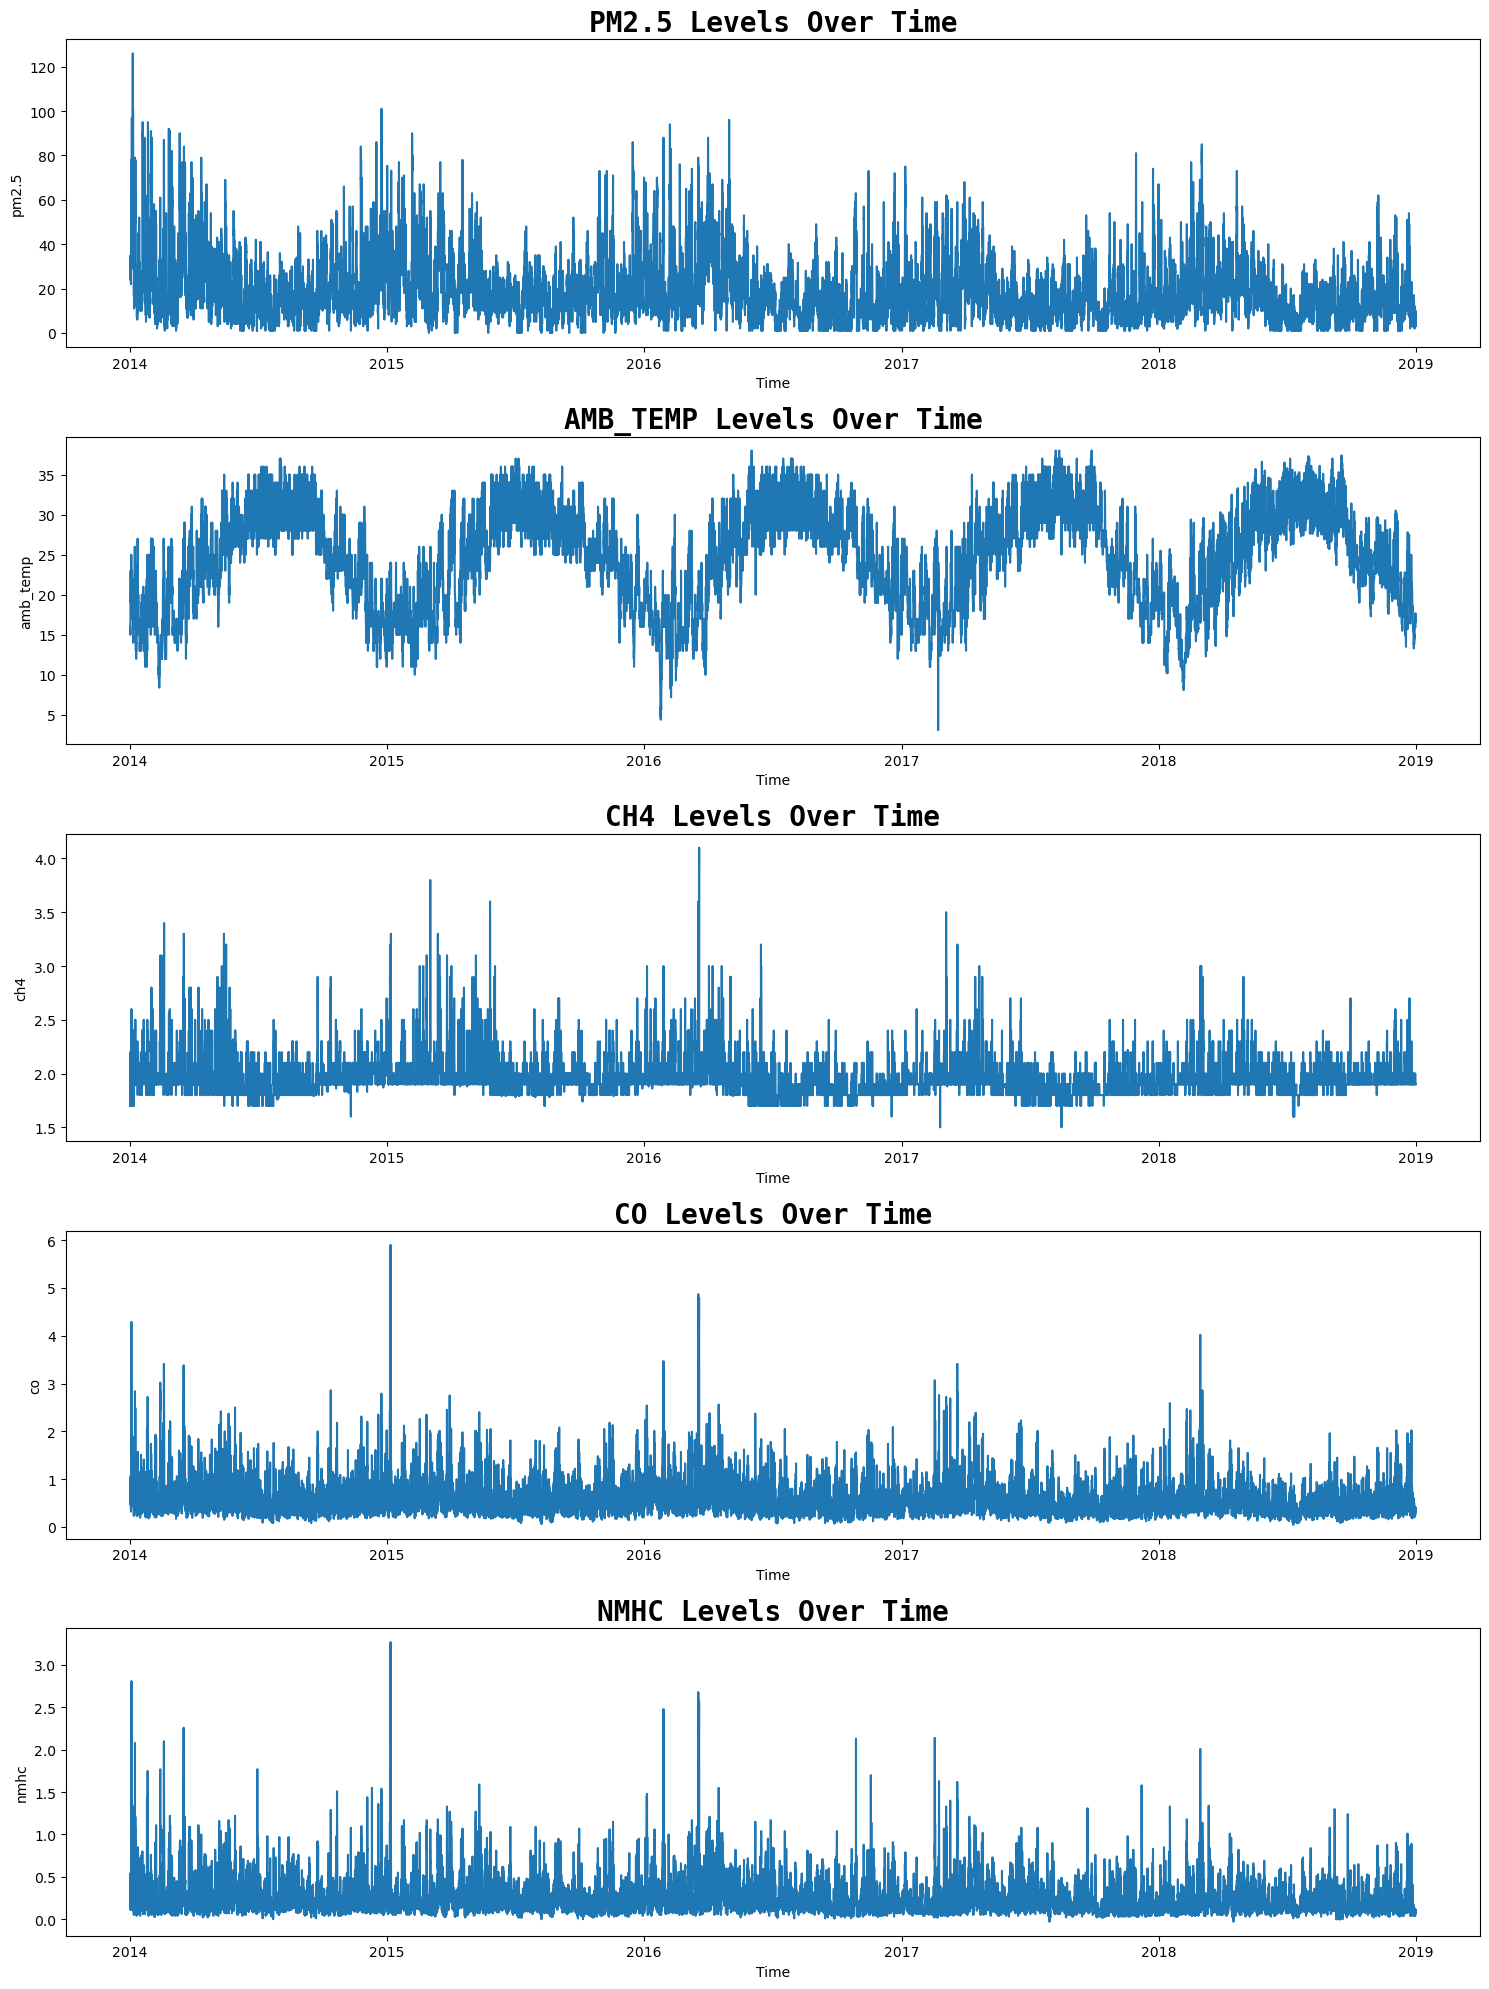

In [114]:
nrow = len(pm25_banqiao.columns[1:-1])
ncols = 1

fig, ax = plt.subplots(
    nrow,
    ncols,
    figsize = (15,4*nrow)
    )

for col, ax in zip(pm25_banqiao.columns[1:-1], ax.flatten()):
    ax.plot(
        pm25_banqiao['read_time'], 
        pm25_banqiao[col],
        linestyle='-',
        )
    ax.set_title(f'{col.upper()} Levels Over Time', fontweight = "bold", fontsize = 20, fontfamily = "monospace")
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{col}')
plt.tight_layout()

# Training Pipeline

- Prepare the model
- Initiate loss and optimization function
- Training process
- Plot the loss curve

# Experimentation

- Prepare different scenario
- Log the experiment
- Monitor the result with MLFlow or tensorboard

# Inferencing

- Load the best model
- Prepare the test data
- Save the result

# Deployment